# Stock EDA and Data Clean Up

### Libraries

In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, TimestampType
from pyspark.sql.functions import isnan, when, count, col, date_format, year, month, dayofmonth, lag,\
round, regexp_replace, max, min, avg, stddev
from pyspark.sql.window import Window

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker

### Spark Session

In [2]:
spark = SparkSession.builder.appName("stock").getOrCreate()
sc = spark.sparkContext
data_file = "gs://stock-sp500/Data/S&P_500_Full_Stock_Data.csv"

### Data Schema

In [3]:
stock_schema = StructType([StructField('Symbol', StringType(), False),
                           StructField('Date', TimestampType(), False),
                           StructField('Open', FloatType(), True),
                           StructField('High', FloatType(), True),
                           StructField('Low', FloatType(), True),
                           StructField('Close', FloatType(), True),
                           StructField('Adj Close', FloatType(), True),
                           StructField('Volume', IntegerType(), True),
                           StructField('Description', StringType(), False),
                           StructField('Category2', StringType(), False),
                           StructField('Category3', StringType(), False),
                           StructField('GICS Sector', StringType(), False)])

### Reading the Data

In [4]:
stock_df = spark.read.csv(data_file,
                          header = True,
                          schema = stock_schema).cache()

### Null and Missing Values

In [5]:
# Only looking at ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] columns because the 
# schema defined the other columns as not nullable.
null_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Number of Null values per column
stock_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in null_columns]).show()

+----+----+---+-----+---------+------+
|Open|High|Low|Close|Adj Close|Volume|
+----+----+---+-----+---------+------+
|   7|   7|  7|    7|        7| 11333|
+----+----+---+-----+---------+------+



In [6]:
# Creating dataframe with the null values
agg_expression = [F.sum(when(stock_df[x].isNull(), 1).otherwise(0)).alias(x) for x in null_columns]
null_values_by_stock = stock_df.groupby("Symbol").agg(*agg_expression)

null_values_by_stock = null_values_by_stock.withColumn('Missing Values Sum', sum([F.col(c) for c in null_columns]))
null_values_by_stock.filter(null_values_by_stock["Missing Values Sum"] > 0).show()

+------+----+----+---+-----+---------+------+------------------+
|Symbol|Open|High|Low|Close|Adj Close|Volume|Missing Values Sum|
+------+----+----+---+-----+---------+------+------------------+
|    EA|   1|   1|  1|    1|        1|  1619|              1624|
|    CI|   1|   1|  1|    1|        1|  1619|              1624|
|   PVH|   1|   1|  1|    1|        1|  1619|              1624|
|  NLOK|   1|   1|  1|    1|        1|  1619|              1624|
|   HPQ|   1|   1|  1|    1|        1|  1619|              1624|
|  BF-B|   1|   1|  1|    1|        1|  1619|              1624|
|   AEE|   1|   1|  1|    1|        1|  1619|              1624|
+------+----+----+---+-----+---------+------+------------------+



In [7]:
# Counting the number of missing values
stock_df_missing_values = stock_df.filter(col("Open").isNull()|col("High").isNull()\
                                         |col("Low").isNull()|col("Close").isNull()\
                                         |col("Adj Close").isNull()|col("Volume").isNull())
print("There are {} rows with missing values.".format(stock_df_missing_values.count()))

There are 11333 rows with missing values.


### Missing Values Matplotlib Visualization

In [8]:
pandas_missing_values = stock_df_missing_values.toPandas()
missing_stock_symbols = pandas_missing_values['Symbol'].unique().tolist()

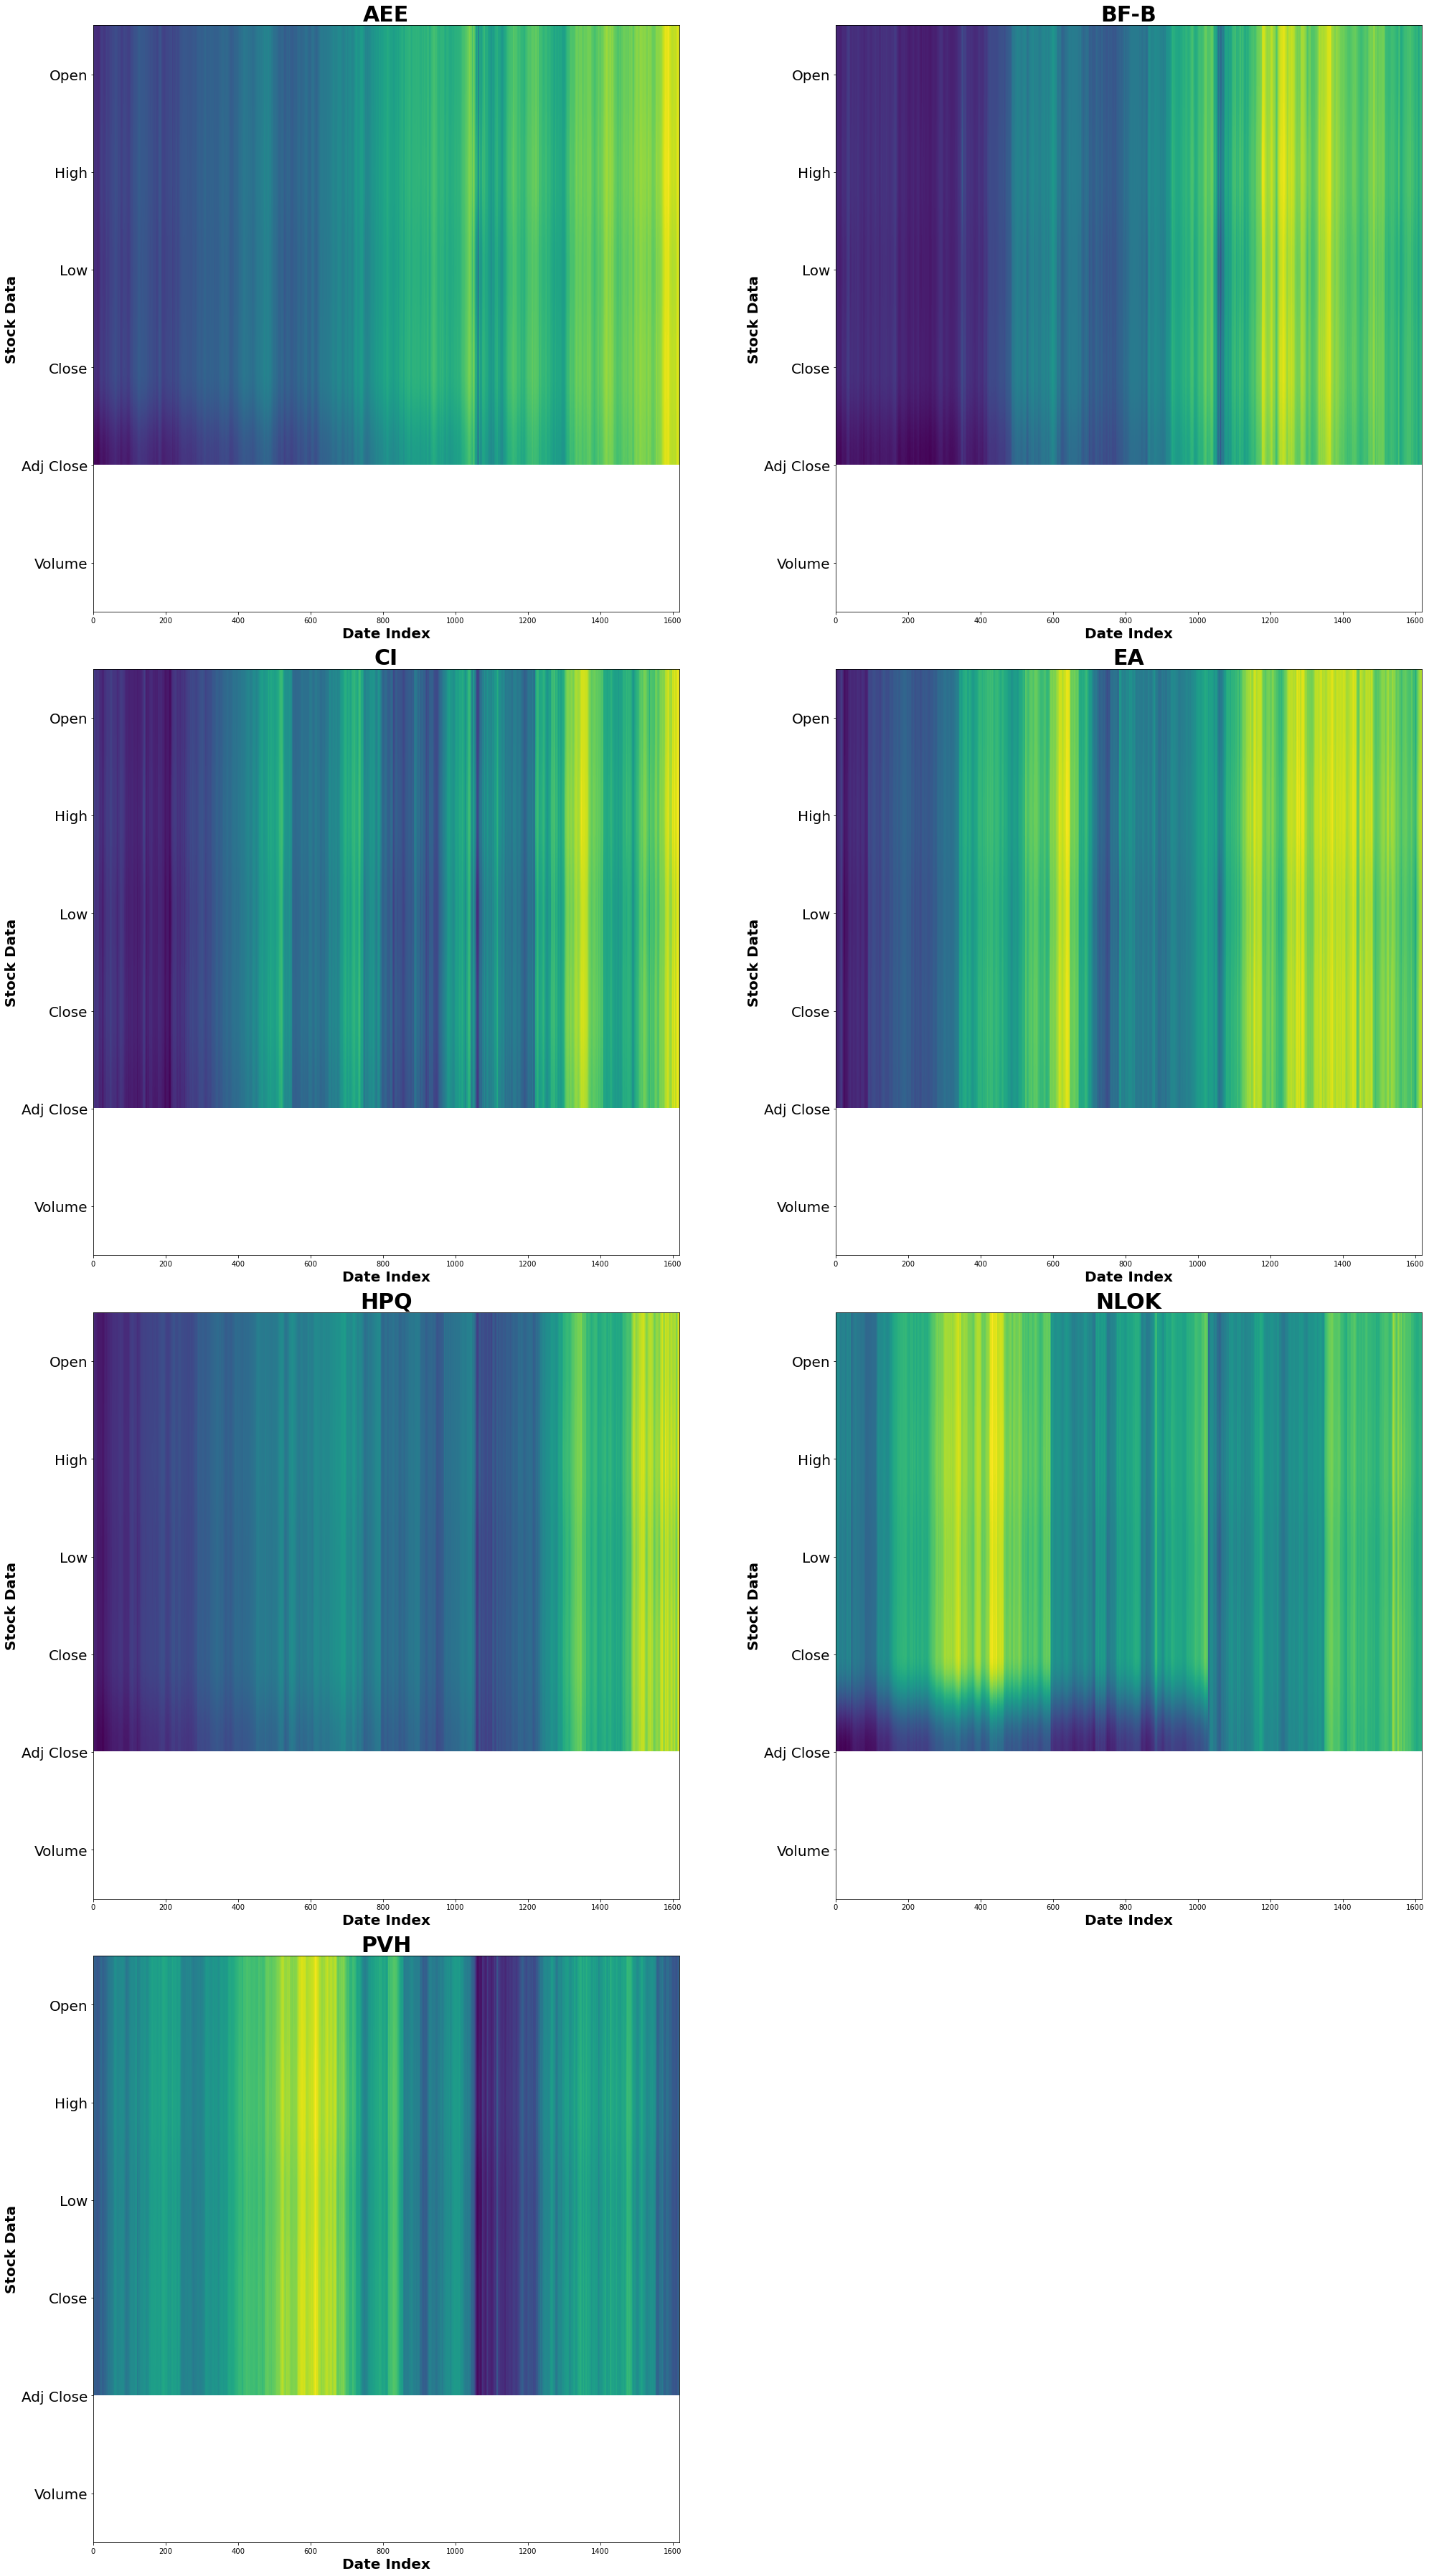

In [9]:
n_cols = 2
n_rows = int(np.ceil(len(missing_stock_symbols)/n_cols))
fig, axes = plt.subplots(nrows=n_rows, 
                         ncols=n_cols, 
                         figsize=(30,50))

for _, ax in zip(missing_stock_symbols, axes.flatten()):
    pandas_missing_values_t = pandas_missing_values[pandas_missing_values['Symbol'] == _]
    pandas_missing_values_t = pandas_missing_values_t[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    pandas_missing_values_t.set_index("Date", inplace = True, drop = True)
    pandas_missing_values_t = pandas_missing_values_t.T
    np_missing_values_array = pandas_missing_values_t.values
    
    missing_dates_array = np.array(pandas_missing_values_t.columns)
    missing_dates_array = missing_dates_array.astype('datetime64[D]')
    missing_dates_array = np.datetime_as_string(missing_dates_array)
    missing_dates_list = missing_dates_array.tolist()

    # Plot heatmap
    ax.set_title(_, fontsize=30, weight='bold')
    ax.set_ylabel('Stock Data', fontsize=20, weight='bold')
    ax.set_xlabel('Date Index', fontsize=20, weight='bold')
    
    positions = [0, 1, 2, 3, 4, 5]
    labels = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
    ax.yaxis.set_tick_params(labelsize=20)

    ax.imshow(np_missing_values_array)
    
    h, w = np_missing_values_array.shape
    ax.set_aspect(w/h)
    
fig.delaxes(axes[n_rows - 1, -1])
plt.tight_layout()  
plt.show()

In [10]:
print('These stocks are all missing values in the Volume row, we will remove them since we will be using them\
in our models.')

These stocks are all missing values in the Volume row, we will remove them since we will be using themin our models.


### Dropping Rows with Null Values

In [11]:
stock_df = stock_df.dropna(how = 'any')
stock_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in null_columns]).show()
print('''Now we don't have any missing values in the main data columns we will be using to model.''')

+----+----+---+-----+---------+------+
|Open|High|Low|Close|Adj Close|Volume|
+----+----+---+-----+---------+------+
|   0|   0|  0|    0|        0|     0|
+----+----+---+-----+---------+------+

Now we don't have any missing values in the main data columns we will be using to model.


### Features

#### Date Feautures: Day of Week, Month, Year

In [12]:
stock_df_new = stock_df.withColumn("day_of_week", date_format(col("Date"), "EEEE"))\
.withColumn("year", year(col("Date")))\
.withColumn("month", month(col("Date")))\
.withColumn("day_of_month", dayofmonth(col("Date")))

#### Lag 1, Lag2, Lag3, Lag4, Lag 5, Lag 6

In [13]:
windowSpec = Window.partitionBy("Symbol").orderBy("Symbol")
stock_df_new = stock_df_new.withColumn("lag_1", lag("Close",1).over(windowSpec))\
.withColumn("lag_2", lag("Close",2).over(windowSpec))\
.withColumn("lag_3", lag("Close",3).over(windowSpec))\
.withColumn("lag_4", lag("Close",4).over(windowSpec))\
.withColumn("lag_5", lag("Close",5).over(windowSpec))\
.withColumn("lag_6", lag("Close",6).over(windowSpec))

#### Daily Return

In [14]:
stock_df_new = stock_df_new.withColumn('daily_return', (stock_df_new['Close'] - stock_df_new['Open']))

#### Cummulative Return

In [15]:
cummulative_window = (Window.partitionBy('Symbol').orderBy('Date').rangeBetween(Window.unboundedPreceding, 0))
stock_df_new = stock_df_new.withColumn('cum_return', F.sum('daily_return').over(cummulative_window))

#### DataFrame Clean-Up

In [16]:
# These are the new features we created
stock_df_new_null_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'day_of_week',
'year', 'month', 'day_of_month', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'daily_return', 'cum_return']

In [17]:
# Due to the lag features created, we need to clean this dataframe up again since we will
# have more null values. (Every stock will be missing the first 6 rows at the beginning)
stock_df_new.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in stock_df_new_null_columns]).show()
print('''Now we have null values again we will take care of.''')

+----+----+---+-----+---------+------+-----------+----+-----+------------+-----+-----+-----+-----+-----+-----+------------+----------+
|Open|High|Low|Close|Adj Close|Volume|day_of_week|year|month|day_of_month|lag_1|lag_2|lag_3|lag_4|lag_5|lag_6|daily_return|cum_return|
+----+----+---+-----+---------+------+-----------+----+-----+------------+-----+-----+-----+-----+-----+-----+------------+----------+
|   0|   0|  0|    0|        0|     0|          0|   0|    0|           0|  496|  992| 1488| 1984| 2480| 2976|           0|         0|
+----+----+---+-----+---------+------+-----------+----+-----+------------+-----+-----+-----+-----+-----+-----+------------+----------+

Now we have null values again we will take care of.


In [18]:
stock_df_new = stock_df_new.dropna(how = 'any')
stock_df_new.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in stock_df_new_null_columns]).show()
print('''Now we don't have any missing values in the main data columns we will be using to model.''')

+----+----+---+-----+---------+------+-----------+----+-----+------------+-----+-----+-----+-----+-----+-----+------------+----------+
|Open|High|Low|Close|Adj Close|Volume|day_of_week|year|month|day_of_month|lag_1|lag_2|lag_3|lag_4|lag_5|lag_6|daily_return|cum_return|
+----+----+---+-----+---------+------+-----------+----+-----+------------+-----+-----+-----+-----+-----+-----+------------+----------+
|   0|   0|  0|    0|        0|     0|          0|   0|    0|           0|    0|    0|    0|    0|    0|    0|           0|         0|
+----+----+---+-----+---------+------+-----------+----+-----+------------+-----+-----+-----+-----+-----+-----+------------+----------+

Now we don't have any missing values in the main data columns we will be using to model.


### GICS Sector Category Clean Up

In [19]:
# There is an Information Technology and Information technology group
stock_df_new = stock_df_new.\
withColumn('GICS Sector', regexp_replace('GICS Sector', 'Information technology', 'Information Technology'))

### EDA

In [20]:
stock_df_new.show(2)

+------+-------------------+-------+-------+------+-------+---------+---------+-----------+-------------+---------+--------------------+-----------+----+-----+------------+-------+-------+-------+-------+-------+-------+------------+-------------------+
|Symbol|               Date|   Open|   High|   Low|  Close|Adj Close|   Volume|Description|    Category2|Category3|         GICS Sector|day_of_week|year|month|day_of_month|  lag_1|  lag_2|  lag_3|  lag_4|  lag_5|  lag_6|daily_return|         cum_return|
+------+-------------------+-------+-------+------+-------+---------+---------+-----------+-------------+---------+--------------------+-----------+----+-----+------------+-------+-------+-------+-------+-------+-------+------------+-------------------+
|  AAPL|2016-01-12 00:00:00|25.1375|25.1725| 24.71|  24.99| 22.94767|196616800|  Apple Inc|Common stocks|Large cap|Information Techn...|    Tuesday|2016|    1|          12|24.6325|  24.24|24.1125| 25.175|25.6775|26.3375| -0.14750099|-1.25

#### Category Counts

In [21]:
print("Distinct Stock Count: {}\n".format(stock_df_new.select('Symbol').distinct().count()))

Distinct Stock Count: 496



In [22]:
tot_count = stock_df_new.count()

cat2_counts = stock_df_new\
.groupBy('Category2')\
.count()\
.withColumn('Propotion %', F.round((F.col('count')/tot_count),2))\
.orderBy('count', ascending=False)


cat3_counts = stock_df_new\
.groupBy('Category3')\
.count()\
.withColumn('Propotion %', F.round((F.col('count')/tot_count),2))\
.orderBy('count', ascending=False)


sector_counts = stock_df_new\
.groupBy('GICS Sector')\
.count()\
.withColumn('Propotion %', F.round((F.col('count')/tot_count),2))\
.orderBy('count', ascending=False)

year_counts = stock_df_new\
.groupBy('year')\
.count()\
.withColumn('Propotion %', F.round((F.col('count')/tot_count),2))\
.orderBy('year', ascending=True)

In [23]:
cat2_counts_df = cat2_counts.toPandas()
cat2_counts_df['str Prop2'] = cat2_counts_df['Propotion %'] * 100
cat2_counts_df['str Prop2'] = cat2_counts_df['str Prop2'].round(2)
cat2_counts_df['str Prop2'] = cat2_counts_df['str Prop2'].astype(str) + '%'

cat3_counts_df = cat3_counts.toPandas()
cat3_counts_df['str Prop3'] = cat3_counts_df['Propotion %'] * 100
cat3_counts_df['str Prop3'] = cat3_counts_df['str Prop3'].round(2)
cat3_counts_df['str Prop3'] = cat3_counts_df['str Prop3'].astype(str) + '%'

sector_counts_df = sector_counts.toPandas()
sector_counts_df['str Prop4'] = sector_counts_df['Propotion %'] * 100
sector_counts_df['str Prop4'] = sector_counts_df['str Prop4'].round(2)
sector_counts_df['str Prop4'] = sector_counts_df['str Prop4'].astype(str) + '%'

year_counts_df = year_counts.toPandas()
year_counts_df['str Prop5'] = year_counts_df['Propotion %'] * 100
year_counts_df['str Prop5'] = year_counts_df['str Prop5'].round(2)
year_counts_df['str Prop5'] = year_counts_df['str Prop5'].astype(str) + '%'

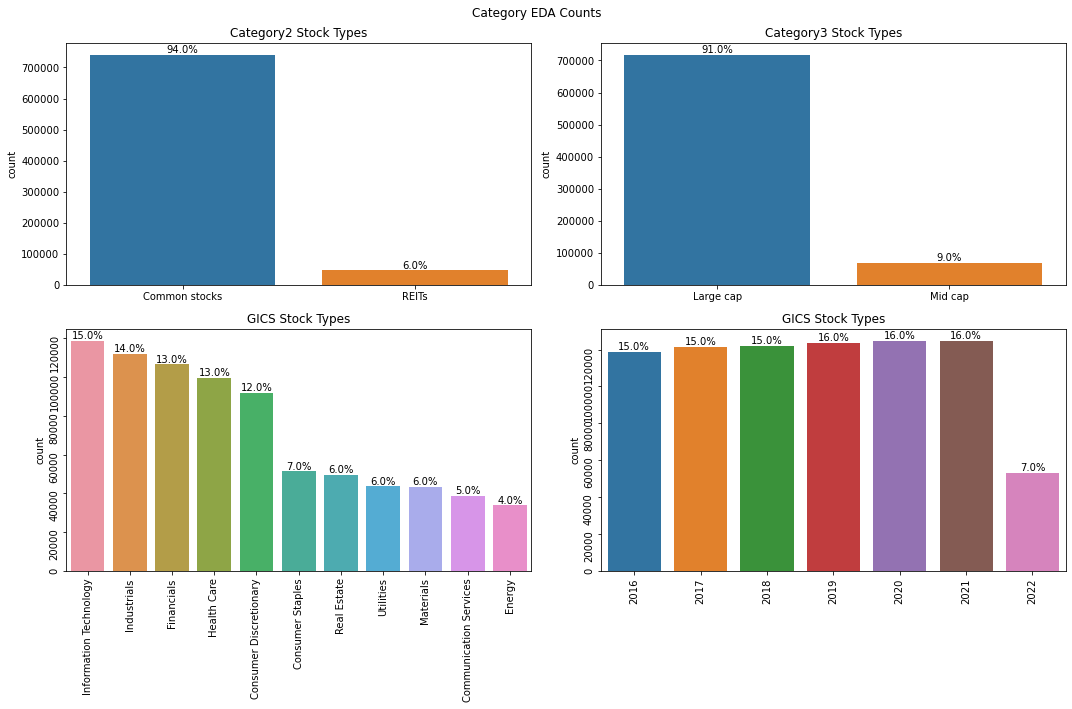

In [24]:
fig, axes = plt.subplots(2,2, figsize=(15, 10), sharey=False)
fig.suptitle('Category EDA Counts')

# Category2
sns.barplot(ax=axes[0,0], x=cat2_counts_df['Category2'], y=cat2_counts_df['count'])
axes[0,0].set_title("Category2 Stock Types")
axes[0,0].bar_label(axes[0,0].containers[0], labels = cat2_counts_df['str Prop2'])
axes[0,0].set(xlabel=None)

# Category3
sns.barplot(ax=axes[0,1], x=cat3_counts_df['Category3'], y=cat3_counts_df['count'])
axes[0,1].set_title("Category3 Stock Types")
axes[0,1].bar_label(axes[0,1].containers[0], labels = cat3_counts_df['str Prop3'])
axes[0,1].set(xlabel=None)

# Category3
sns.barplot(ax=axes[1,0], x=sector_counts_df['GICS Sector'], y=sector_counts_df['count'])
axes[1,0].set_title("GICS Stock Types")
axes[1,0].bar_label(axes[1,0].containers[0], labels = sector_counts_df['str Prop4'])
axes[1,0].tick_params(labelrotation=90)
axes[1,0].set(xlabel=None)

# Category3
sns.barplot(ax=axes[1,1], x=year_counts_df['year'], y=year_counts_df['count'])
axes[1,1].set_title("GICS Stock Types")
axes[1,1].bar_label(axes[1,1].containers[0], labels = year_counts_df['str Prop5'])
axes[1,1].tick_params(labelrotation=90)
axes[1,1].set(xlabel=None)

fig.tight_layout()
fig.show()

#### Best Day of the Week to Buy Stocks

In [25]:
best_time_to_buy = stock_df_new.groupBy('day_of_week')\
.agg(F.round(min('Close'), 2).alias('Close_min'),
     F.round(max('Close'), 2).alias('Close_max'),
     F.round(avg('Close'), 2).alias('Close_avg'),
     F.round(F.percentile_approx("Close", 0.5), 2).alias("Close_med"),
     F.round(stddev('Close'), 2).alias('Close_stddev'))\
.orderBy(when(col("day_of_week") == "Monday", 1)\
         .when(col("day_of_week") == "Tuesday", 2)\
         .when(col("day_of_week") == "Wednesday", 3)\
         .when(col("day_of_week") == "Thursday", 4)\
         .when(col("day_of_week") == "Friday", 5))

In [26]:
best_time_to_buy_df = best_time_to_buy.toPandas()
best_time_to_buy_df["Close_med"] = best_time_to_buy_df["Close_med"].astype(float).round(2)
best_time_to_buy_df["Close_avg"] = best_time_to_buy_df["Close_avg"].astype(float).round(2)

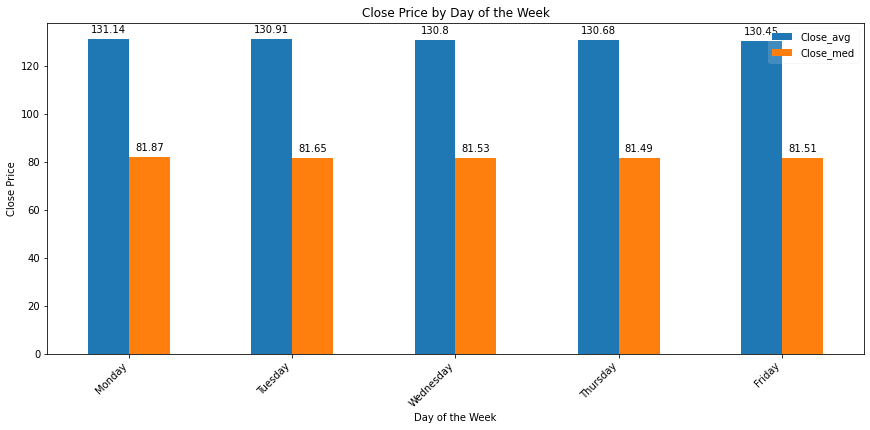

In [27]:
fig, ax1 = plt.subplots(figsize=(12,6))
best_day_plot = best_time_to_buy_df[["day_of_week", "Close_avg", "Close_med"]].plot.bar(x='day_of_week', ax=ax1)


for p in best_day_plot.patches:
    best_day_plot.annotate(format(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')

plt.tight_layout()
plt.xticks(rotation=45, ha="right")
plt.xlabel("Day of the Week")
plt.ylabel("Close Price")
plt.title("Close Price by Day of the Week")
plt.legend(loc="upper right", framealpha=0.15)
plt.show()

#### Most Valuable Stocks by GCIS 

In [28]:
best_sector = stock_df_new.groupBy('GICS Sector')\
.agg(F.round(avg('Close'), 2).alias('Close_avg'),
     F.round(F.percentile_approx("Close", 0.5), 2).alias("Close_med"),
     F.round(stddev('Close'), 2).alias('Close_stddev'))

In [29]:
best_sector_df = best_sector.toPandas()
best_sector_df.sort_values(by = "Close_avg", inplace = True, ascending = False)
best_sector_df.reset_index(inplace = True, drop = True)
best_sector_df["Close_med"] = best_sector_df["Close_med"].astype(float).round(2)
best_sector_df["Close_avg"] = best_sector_df["Close_avg"].astype(float).round(2)

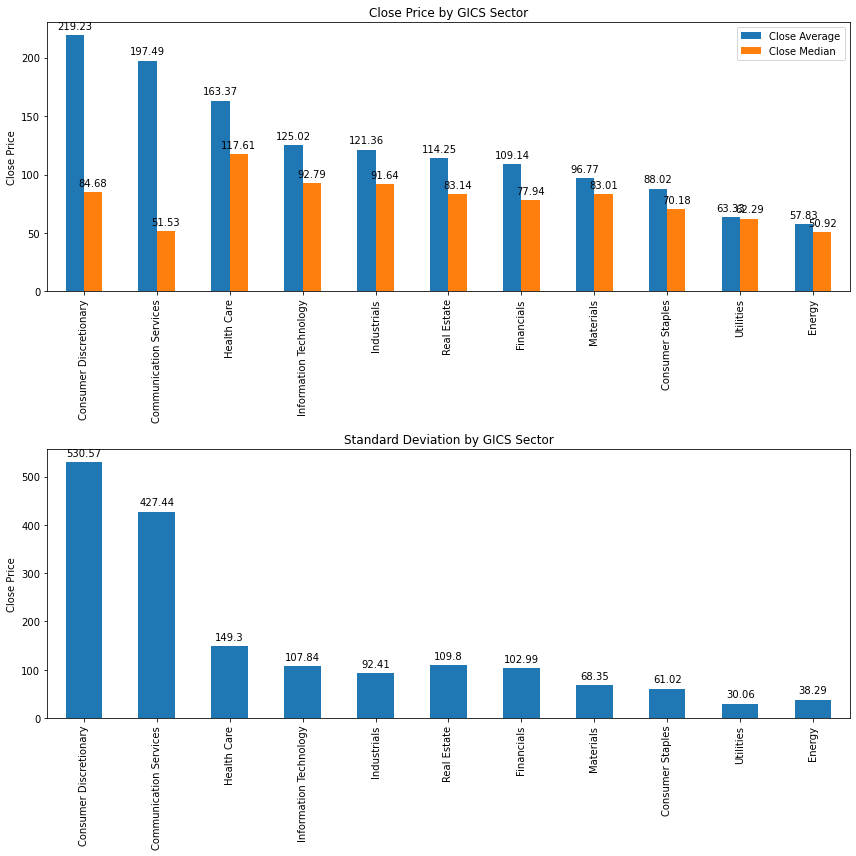

In [30]:
fig, ((ax1), (ax2)) = plt.subplots(2,1,figsize=(12,12))
best_sect_plot1 = best_sector_df[["GICS Sector", "Close_avg", "Close_med"]].plot.bar(x='GICS Sector', ax=ax1)
for p in best_sect_plot1.patches:
    best_sect_plot1.annotate(format(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')    
ax1.set_title('Close Price by GICS Sector')
ax1.set_xlabel('')
ax1.set_ylabel('Close Price')    
ax1.legend(['Close Average', 'Close Median']) 
    
best_sect_plot2 = best_sector_df[["GICS Sector", "Close_stddev"]].plot.bar(x='GICS Sector', ax=ax2)   
for p in best_sect_plot2.patches:
    best_sect_plot2.annotate(format(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')  
ax2.set_title('Standard Deviation by GICS Sector')
ax2.set_xlabel('')
ax2.set_ylabel('Close Price')
ax2.legend().set_visible(False)
    
plt.tight_layout()
plt.show()

#### Average Daily Returns by Sector

In [31]:
dr_by_sector = stock_df_new.groupBy('GICS Sector')\
.agg(F.round(avg('daily_return'), 2).alias('dr_avg'),
     F.round(F.percentile_approx("daily_return", 0.5), 2).alias("dr_med"),
     F.round(stddev('daily_return'), 2).alias('dr_stddev'))

In [32]:
dr_by_sector.show()

+--------------------+------+------+---------+
|         GICS Sector|dr_avg|dr_med|dr_stddev|
+--------------------+------+------+---------+
|         Health Care|  0.02|  0.04|     3.76|
|Communication Ser...|  0.02|   0.0|      6.7|
|              Energy| -0.01| -0.01|     1.25|
|Information Techn...|   0.0|  0.04|     3.13|
|         Real Estate| -0.01|  0.03|     2.39|
|           Materials| -0.01|   0.0|     1.77|
|Consumer Discreti...|  0.01|  0.01|    10.17|
|           Utilities|  0.02|  0.03|     0.91|
|    Consumer Staples|  0.01|  0.03|     1.38|
|         Industrials|   0.0|  0.03|     2.34|
|          Financials| -0.01|  0.02|     2.37|
+--------------------+------+------+---------+



#### Average, Median and Standard Deviation by Stock

In [33]:
avg_by_symbol = stock_df_new.groupBy('Symbol')\
.agg(F.round(avg('Open'), 2).alias('open_avg'),
     F.round(avg('High'), 2).alias('high_avg'),
     F.round(avg('Low'), 2).alias('low_avg'),
     F.round(avg('Close'), 2).alias('close_avg'),
     F.round(avg('Adj Close'), 2).alias('adj_close_avg'),
     F.round(avg('Volume'), 2).alias('volume_avg'),
     F.round(avg('daily_return'), 2).alias('dr_avg'),
     F.round(avg('cum_return'), 2).alias('cum_avg'))

In [34]:
avg_by_symbol.show(4)

+------+--------+--------+-------+---------+-------------+--------------+------+-------+
|Symbol|open_avg|high_avg|low_avg|close_avg|adj_close_avg|    volume_avg|dr_avg|cum_avg|
+------+--------+--------+-------+---------+-------------+--------------+------+-------+
|  AAPL|   73.14|   73.97|  72.35|     73.2|        71.82|1.2394444777E8|  0.05|  29.77|
|  ABMD|  238.06|  242.08| 233.88|   238.11|       238.11|      490611.6|  0.05|  86.57|
|   ADI|  108.16|  109.38| 106.86|   108.17|       102.74|    2930779.71|  0.01|  15.26|
|   ALL|   97.83|   98.72|  96.98|    97.86|        91.49|    1978268.24|  0.03|   26.8|
+------+--------+--------+-------+---------+-------------+--------------+------+-------+
only showing top 4 rows



In [35]:
med_by_symbol = stock_df_new.groupBy('Symbol')\
.agg(F.round(F.percentile_approx("Open", 0.5), 2).alias("open_med"),
     F.round(F.percentile_approx("High", 0.5), 2).alias("high_med"),
     F.round(F.percentile_approx("Low", 0.5), 2).alias("low_med"),
     F.round(F.percentile_approx("Close", 0.5), 2).alias("close_med"),
     F.round(F.percentile_approx("Adj Close", 0.5), 2).alias("adj_close_med"),
     F.round(F.percentile_approx("Volume", 0.5), 2).alias("volume_med"),
     F.round(F.percentile_approx("daily_return", 0.5), 2).alias("dr_med"),
     F.round(F.percentile_approx("cum_return", 0.5), 2).alias("cum_med"))

In [36]:
med_by_symbol.show(4)

+------+--------+--------+-------+---------+-------------+----------+------+-------+
|Symbol|open_med|high_med|low_med|close_med|adj_close_med|volume_med|dr_med|cum_med|
+------+--------+--------+-------+---------+-------------+----------+------+-------+
|  AAPL|   50.79|   51.24|  50.41|    50.81|        49.55| 108776000|  0.05|  18.15|
|  ABMD|  259.08|   263.5| 254.41|   260.33|       260.33|    389500|  0.12|  72.38|
|   ACN|  169.21|  171.01| 167.84|   169.45|       160.88|   2002200|  0.14|  74.35|
|   ADI|  101.05|   102.1|  99.73|   101.05|        94.51|   2582300|  0.03|  13.98|
+------+--------+--------+-------+---------+-------------+----------+------+-------+
only showing top 4 rows



### Correlation

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

numeric_columns = ['Open','High', 'Low', 'Close', 'Adj Close', 'Volume']
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_col)
df_vector = assembler.transform(stock_df_new).select(vector_col)

# get correlation matrix
corr_matrix = Correlation.corr(df_vector, vector_col)
pearson_corr_matrix = corr_matrix.collect()[0]["pearson({})".format(vector_col)].values
pearson_corr_matrix = pearson_corr_matrix.reshape((len(numeric_columns), len(numeric_columns)))

In [ ]:
pearson_corr_matrix

In [ ]:
heatmap = plt.pcolor(pearson_corr_matrix)

for y in range(pearson_corr_matrix.shape[0]):
    for x in range(pearson_corr_matrix.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.2f' % pearson_corr_matrix[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

plt.colorbar(heatmap)

plt.show()

In [ ]:
pearson_corr_matrix

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(pearson_corr_matrix)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(numeric_columns)), labels=numeric_columns)
ax.set_yticks(np.arange(len(numeric_columns)), labels=numeric_columns)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(numeric_columns)):
    for j in range(len(numeric_columns)):
        text = ax.text(j, i, pearson_corr_matrix[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()